In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs, remove
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import scipy
from scipy.stats import kendalltau
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [9]:
list_sn = su.get_list_sn()
list_sn

array(['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13',
       '14'], dtype='<U2')

---

In [10]:
dir_roi = su.get_dir_roi()

In [11]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')
hem = 'L'

In [12]:
fname = join(dir_roi,'SPark2025.32k.L.label.gii')
gii = nb.load(fname)
mask = gii.darrays[0].data

In [13]:
list_roi = []
for ii, label in enumerate(gii.labeltable.labels):
    if ii>0:
        list_roi.append(label.label)
del gii
list_roi = np.array(list_roi)
list_roi

array(['S1', 'M1', 'SMA', 'PMd', 'PMv', 'SPLa', 'SPLp', 'IPS', 'V4d',
       'Vf', 'Vd', 'Vv', 'POS', 'PGi'], dtype='<U4')

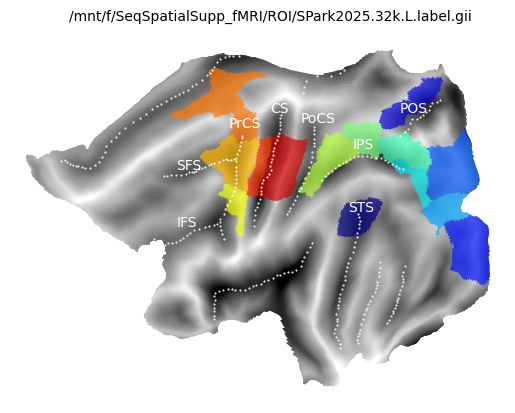

In [14]:
g = surf.plot.plotmap(
    data=mask,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet_r.resampled(len(np.unique(mask))),
    # colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='white', bordersize=1,
    overlay_type='func', render='matplotlib',
)
g.text(x=20, y=220, s=fname, ha='center', va='center', fontsize=10)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

---

In [15]:
glm = 1

In [16]:
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

In [17]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

---

---
---

In [17]:
for sn in tqdm(list_sn):
    subj = 'S'+sn
    reginfo = deal_spm.load_reginfo(subj=subj, dir_glm=dir_glm)
    part_vec = reginfo.run.values.flatten()
    if 'GLMsingle' in dir_glm:
        cond_vec = reginfo.name.values.flatten()
    else:
        cond_vec = reginfo.reg.values.flatten()
    list_nii = sorted(glob(join(dir_glm,subj,'beta_*.nii')))
    white, pial, mask = simage.get_WPM(subj=subj, glm=glm)
    dataset = []
    for roi, label in zip(list_roi, list_label):
        atlas, ainfo = am.get_atlas('fs32k_%s'%h)
        subatlas = atlas.get_subatlas_image(
            mask_img=join(atlasDir,'ROI.32k.%s.label.gii'%h),
            value=label
        )
        amap = am.AtlasMapSurf(
            vertex=subatlas.vertex[0],
            white_surf=white,
            pial_surf=pial,
            mask_img=mask
        )
        
        ## Compute the voxels in native space
        amap.build()
        
        ## This extract all the relevant voxels in native space (use for RSA)
        beta = amap.extract_data_native(list_nii)
        idx_nan = np.isnan(beta).any(axis=0)
        beta = beta[:, ~idx_nan]
        dataset.append(beta)

    ## save the data of hem and region:
    ## Convert to object array to handle different shapes
    dataset_obj = np.empty(len(dataset), dtype=object)
    for ii, data in enumerate(dataset):
        dataset_obj[ii] = data

    np.savez(
        file=join(dir_glm,'beta.%s.%s.%drois.npz'%(h,subj,len(list_roi))), 
        dataset=dataset_obj,
        cond_vec=cond_vec,
        part_vec=part_vec,
        subj=subj
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [1:18:47<00:00, 393.95s/it]
